# Grid South Africa Gravity Survey

In [1]:
from IPython.display import display
from pathlib import Path
import warnings
import pyproj
import dask
import numpy as np
import boule as bl
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from boost_and_layouts import (
    block_averaged_sources,
    combine_parameters,
    EQLHarmonicBoost,
    save_to_json,
)


Define results directory

In [2]:
results_dir = Path("..") / "results" / "south_africa"

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fetch South Africa gravity data

In [3]:
data = hm.datasets.fetch_south_africa_gravity()
display(data)

,latitude,longitude,elevation,gravity
0,-34.39150,17.71900,-589.0,979724.79
1,-34.48000,17.76100,-495.0,979712.90
2,-34.35400,17.77433,-406.0,979725.89
3,-34.13900,17.78500,-267.0,979701.20
4,-34.42200,17.80500,-373.0,979719.00
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


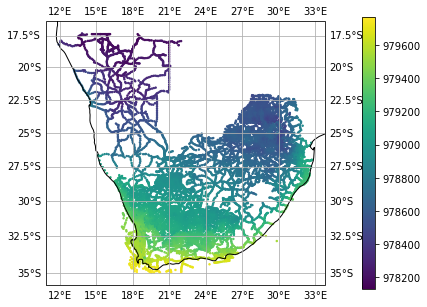

In [4]:
ax = plt.axes(projection=ccrs.Mercator())

fig = plt.gcf()
fig.set_size_inches(6.66, 6.66)

ax.coastlines()
ax.gridlines(draw_labels=True)

tmp = ax.scatter(
    data.longitude, data.latitude, c=data.gravity, s=2, transform=ccrs.PlateCarree()
)

plt.colorbar(tmp, ax=ax, pad=0.1, shrink=0.75)
plt.show()

Project data into Cartesian coordinates

In [5]:
lat_ts = (data.latitude.min() + data.latitude.max()) / 2
projection = pyproj.Proj(proj="merc", lat_ts=lat_ts, ellps="WGS84")
easting, northing = projection(data.longitude.values, data.latitude.values)

coordinates = (easting, northing, data.elevation.values)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


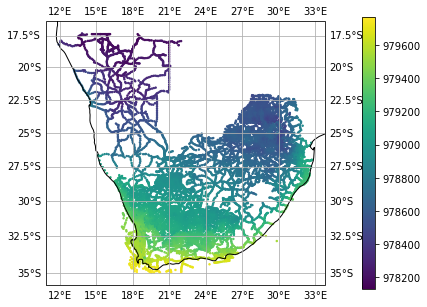

In [6]:
ax = plt.axes(projection=ccrs.Mercator())

fig = plt.gcf()
fig.set_size_inches(6.66, 6.66)

ax.coastlines()
ax.gridlines(draw_labels=True)

tmp = ax.scatter(
    data.longitude, data.latitude, c=data.gravity, s=2, transform=ccrs.PlateCarree()
)

plt.colorbar(tmp, ax=ax, pad=0.1, shrink=0.75)
plt.show()

Compute gravity disturbance by removing normal gravity

In [7]:
ellipsoid = bl.WGS84
gravity_disturbance = data.gravity.values - ellipsoid.normal_gravity(
    data.latitude, data.elevation
)

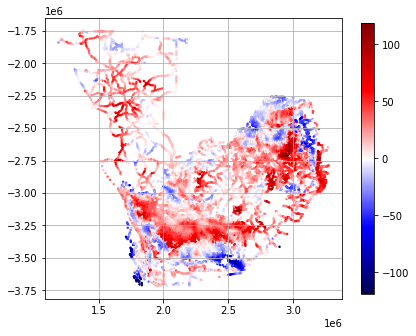

In [8]:
q = 99.9
vmax = np.percentile(gravity_disturbance, q)
vmin = -np.percentile(-gravity_disturbance, q)
maxabs = max(abs(vmin), abs(vmax))

fig, ax = plt.subplots(figsize=(6.66, 6.66))
tmp = ax.scatter(
    easting,
    northing,
    c=gravity_disturbance,
    vmin=-maxabs,
    vmax=maxabs,
    s=2,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax, shrink=0.75)
ax.grid()
ax.set_aspect("equal")
plt.show()

## Grid gravity disturbance using block-averaged sources with variable depth

Define sets of parameters for the equivalent layer

In [9]:
depth_type = "variable_depth"
spacing = 15e3
k_nearest = 10
depth_factors = [0.05, 0.1, 0.5]
dampings = [1e2, 1e3, 1e4]
depths = [2e3, 5e3, 7e3, 10e3]

# Combine these parameters
parameter_sets = combine_parameters(
    **dict(
        depth_type=depth_type,
        depth=depths,
        depth_factor=depth_factors,
        damping=dampings,
        spacing=spacing,
        k_nearest=k_nearest,
    )
)
print("Number of combinations:", len(parameter_sets))

Number of combinations: 36


Check how many sources are created with the chosen spacing

In [10]:
points = block_averaged_sources(coordinates, **parameter_sets[0])
print("Number of data points: {}".format(coordinates[0].size))
print("Number of sources: {}".format(points[0].size))

Number of data points: 14559
Number of sources: 5476


Dump parameters to a JSON file

In [11]:
json_file = results_dir / "parameters-eqlharmonic.json"
save_to_json(parameter_sets, json_file)

Score the prediction made by each set of parameters through cross-validation

In [12]:
%%time
cv = vd.BlockKFold(spacing=100e3, shuffle=True, random_state=0)

scores_delayed = []
for parameters in parameter_sets:
    points = block_averaged_sources(coordinates, **parameters)
    eql = hm.EQLHarmonic(damping=parameters["damping"], points=points)
    score = np.mean(
        vd.cross_val_score(
            eql,
            coordinates,
            gravity_disturbance,
            cv=cv,
            scoring="neg_root_mean_squared_error",
            delayed=True,
        )
    )
    scores_delayed.append(score)

scores = dask.compute(*scores_delayed)

CPU times: user 1h 9min 46s, sys: 1h 53min 52s, total: 3h 3min 39s
Wall time: 19min 6s


Get the set of parameters that achieve the best score

In [13]:
best_score = np.max(scores)
best_parameters = parameter_sets[np.argmax(scores)]

print(best_score)
print(best_parameters)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-19.3314936455567
{'depth_type': 'variable_depth', 'depth': 7000.0, 'depth_factor': 0.1, 'damping': 1000.0, 'spacing': 15000.0, 'k_nearest': 10}


Grid the data using the best set of parameters

In [14]:
%%time
points = block_averaged_sources(coordinates, **best_parameters)
eql = hm.EQLHarmonic(damping=best_parameters["damping"], points=points)
eql.fit(coordinates, gravity_disturbance)

grid = eql.grid(
    upward=3000,
    region=vd.get_region((data.longitude, data.latitude)),
    spacing=0.05,
    data_names=["gravity_disturbance"],
    projection=projection,
)

CPU times: user 23.5 s, sys: 8.44 s, total: 32 s
Wall time: 11.7 s


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


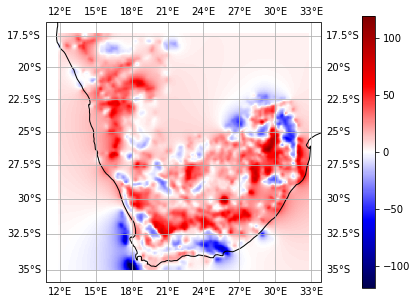

In [15]:
ax = plt.axes(projection=ccrs.Mercator())

fig = plt.gcf()
fig.set_size_inches(6.66, 6.66)

ax.coastlines()
ax.gridlines(draw_labels=True)

tmp = grid.gravity_disturbance.plot.pcolormesh(
    ax=ax,
    vmin=-maxabs,  # use the same colorscale used for the data
    vmax=maxabs,
    cmap="seismic",
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
)

plt.colorbar(tmp, ax=ax, pad=0.11, shrink=0.75)
plt.show()

Mask values outside the convex hull

In [16]:
grid = vd.distance_mask(
    data_coordinates=(data.longitude, data.latitude),
    maxdist=50e3,
    grid=grid,
    projection=projection,
)

Plot gridded data

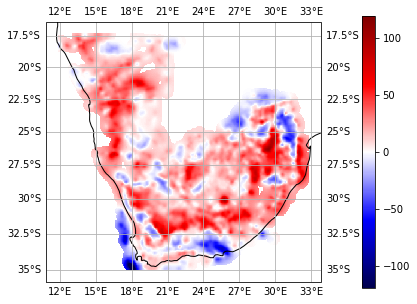

In [17]:
ax = plt.axes(projection=ccrs.Mercator())

fig = plt.gcf()
fig.set_size_inches(6.66, 6.66)

ax.coastlines()
ax.gridlines(draw_labels=True)

tmp = grid.gravity_disturbance.plot.pcolormesh(
    ax=ax,
    vmin=-maxabs,  # use the same colorscale used for the data
    vmax=maxabs,
    cmap="seismic",
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
)

plt.colorbar(tmp, ax=ax, pad=0.11, shrink=0.75)
plt.show()

Save grid to disk

In [18]:
grid.to_netcdf(results_dir / "south_africa_gravity_grid.nc")

## Grid gravity disturbance with EQLHarmonicBoost

Define sets of parameters for the equivalent layer

In [19]:
depth_type = "variable_depth"
spacing = 15e3
k_nearest = 10
depth_factors = [0.05, 0.1, 0.5]
dampings = [1e2, 1e3, 1e4]
depths = [5e3, 7e3, 10e3, 15e3]
window_size = 500e3
random_state = 0

# Combine these parameters
parameter_sets = combine_parameters(
    **dict(
        depth_type=depth_type,
        depth=depths,
        depth_factor=depth_factors,
        damping=dampings,
        spacing=spacing,
        k_nearest=k_nearest,
        window_size=window_size,
        random_state=random_state,
    )
)
print("Number of combinations:", len(parameter_sets))

Number of combinations: 36


Check how many sources are created with the chosen spacing

In [20]:
points = block_averaged_sources(coordinates, **parameter_sets[0])
print("Number of data points: {}".format(coordinates[0].size))
print("Number of sources: {}".format(points[0].size))

Number of data points: 14559
Number of sources: 5476


Dump parameters to a JSON file

In [21]:
json_file = results_dir / "parameters-eql-boost.json"
save_to_json(parameter_sets, json_file)

Score the prediction made by each set of parameters through cross-validation

In [22]:
%%time
cv = vd.BlockKFold(spacing=100e3, shuffle=True, random_state=0)

scores_delayed = []
with warnings.catch_warnings():
    # Disable warnings
    # (we expect some warnings during CV due to underdetermined problems)
    warnings.simplefilter("ignore")
    for parameters in parameter_sets:
        points = block_averaged_sources(coordinates, **parameters)
        eql = EQLHarmonicBoost(
            points=points,
            window_size=parameters["window_size"],
            damping=parameters["damping"],
            random_state=parameters["random_state"],
        )
        score = np.mean(
            vd.cross_val_score(
                eql,
                coordinates,
                gravity_disturbance,
                cv=cv,
                scoring="neg_root_mean_squared_error",
                delayed=True,
            )
        )
        scores_delayed.append(score)

    scores = dask.compute(*scores_delayed)

CPU times: user 17min 11s, sys: 48min, total: 1h 5min 12s
Wall time: 4min 27s


Get the set of parameters that achieve the best score

In [23]:
best_score = np.max(scores)
best_parameters = parameter_sets[np.argmax(scores)]

print(best_score)
print(best_parameters)

-20.9129479007253
{'depth_type': 'variable_depth', 'depth': 10000.0, 'depth_factor': 0.1, 'damping': 1000.0, 'spacing': 15000.0, 'k_nearest': 10, 'window_size': 500000.0, 'random_state': 0}


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grid the data using the best set of parameters

In [24]:
%%time
points = block_averaged_sources(coordinates, **best_parameters)
eql = EQLHarmonicBoost(
    points=points,
    damping=best_parameters["damping"],
    window_size=best_parameters["window_size"],
    random_state=best_parameters["random_state"],
)

eql.fit(coordinates, gravity_disturbance)

grid_boost = eql.grid(
    upward=3000,
    region=vd.get_region((data.longitude, data.latitude)),
    spacing=0.05,
    data_names=["gravity_disturbance"],
    projection=projection,
)

CPU times: user 11.7 s, sys: 34.9 s, total: 46.6 s
Wall time: 3.19 s


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


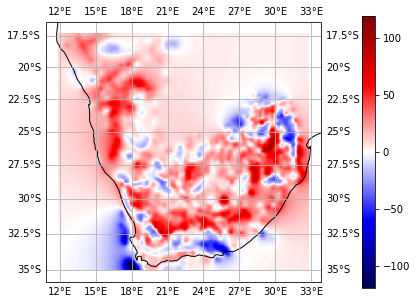

In [25]:
ax = plt.axes(projection=ccrs.Mercator())

fig = plt.gcf()
fig.set_size_inches(6.66, 6.66)

ax.coastlines()
ax.gridlines(draw_labels=True)

tmp = grid_boost.gravity_disturbance.plot.pcolormesh(
    ax=ax,
    vmin=-maxabs,  # use the same colorscale used for the data
    vmax=maxabs,
    cmap="seismic",
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
)

plt.colorbar(tmp, ax=ax, pad=0.11, shrink=0.75)
plt.show()

Mask values outside the convex hull

In [26]:
grid_boost = vd.distance_mask(
    data_coordinates=(data.longitude, data.latitude),
    maxdist=50e3,
    grid=grid_boost,
    projection=projection,
)

Plot gridded data

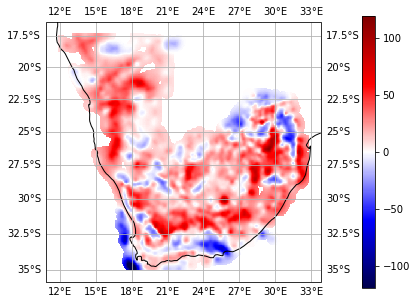

In [27]:
ax = plt.axes(projection=ccrs.Mercator())

fig = plt.gcf()
fig.set_size_inches(6.66, 6.66)

ax.coastlines()
ax.gridlines(draw_labels=True)

tmp = grid_boost.gravity_disturbance.plot.pcolormesh(
    ax=ax,
    vmin=-maxabs,  # use the same colorscale used for the data
    vmax=maxabs,
    cmap="seismic",
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
)

plt.colorbar(tmp, ax=ax, pad=0.11, shrink=0.75)
plt.show()

Save grid to disk

In [28]:
grid_boost.to_netcdf(results_dir / "south_africa_gravity_grid_boost.nc")

## Compare both grids

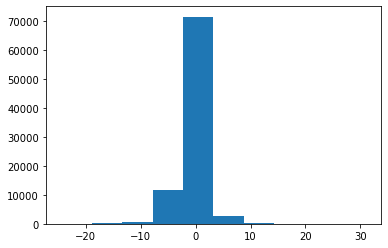

RMS: 2.509164314513856


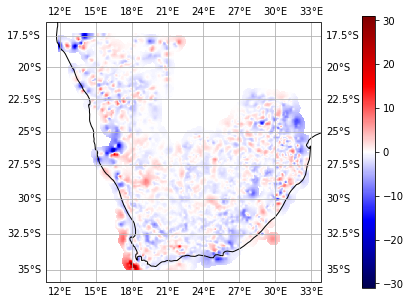

In [29]:
# Compute the difference between the two grids
difference = grid.gravity_disturbance - grid_boost.gravity_disturbance

# Plot histogram of differences
plt.hist(difference.values.ravel())
plt.show()

# Calculate Root mean square of the difference
print("RMS:", np.sqrt(np.nanmean(difference.values ** 2)))

# Plot pcolormesh of differences
ax = plt.axes(projection=ccrs.Mercator())
fig = plt.gcf()
fig.set_size_inches(6.66, 6.66)
ax.coastlines()
ax.gridlines(draw_labels=True)
tmp = difference.plot.pcolormesh(
    ax=ax,
    cmap="seismic",
    add_colorbar=False,
    transform=ccrs.PlateCarree(),
)
plt.colorbar(tmp, ax=ax, pad=0.11, shrink=0.75)
plt.show()